In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

%matplotlib notebook

In [2]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(50, 100, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(100, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(150, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(200, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(250, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/1000.0]*1000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(d[2], fs)] + [filt(x, fs) for x in d[4:9]] + [button])
    
    

In [3]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    
    en = np.array(np.where(xt == -1))[0]
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(6):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [4]:
files = ["b_front_" + str(i) + ".txt" for i in range(1,6)]
#files = ["index.txt", "middle.txt", "ring.txt", "little.txt"]
read_dat = [readFile(_) for _ in files]
feats = [extract_feat(_, feat) for _ in read_dat]

Reading: b_front_1.txt
Reading: b_front_2.txt
Reading: b_front_3.txt
Reading: b_front_4.txt
Reading: b_front_5.txt
64 64
79 79
73 73
89 89
88 88


In [5]:
for i in feats:
    print(len(i), i[0])

64 [197.59699075 126.25256472  67.4753979  119.64887731 266.78079344
  74.43767096]
79 [160.89891679 153.27234673  62.24051974 151.78317603 113.4544372
  55.96145506]
73 [180.44738741  95.84330532  65.91731625 171.2479418  102.94021809
 109.64571386]
89 [ 84.5306914   93.64691962 175.92575712 151.49375573 173.50615451
  98.12339128]
88 [126.41056716 153.70938939 109.00529106 109.83589585 166.55955963
  64.00292924]


<IPython.core.display.Javascript object>


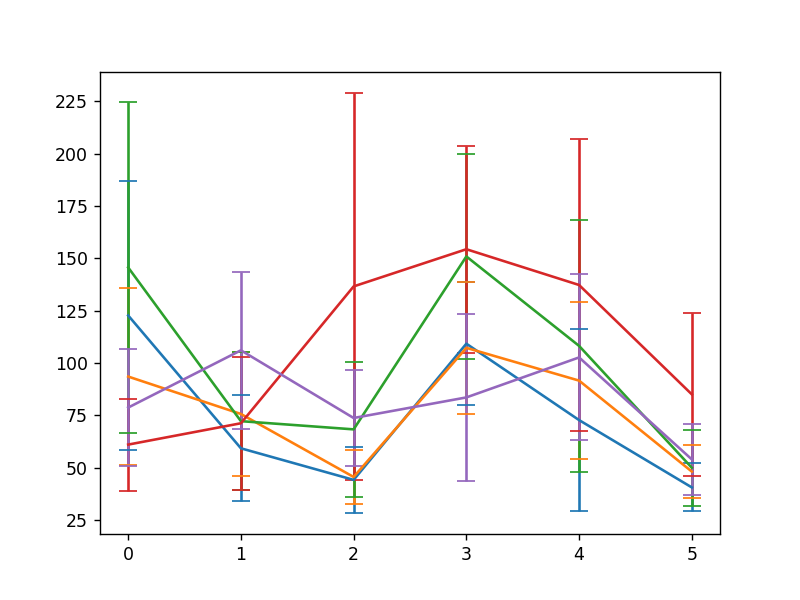

In [6]:
plt.figure()

colors = ["green", "red", "yellow", "blue", "orange"]

for ci,fe in enumerate(feats):
    fe = fe.swapaxes(0,1)
    #print(np.mean(fe, 1), np.std(fe, 1))
    plt.errorbar(range(6), np.mean(fe, 1), np.std(fe, 1), capsize=5)
    
    #for i in range(len(fe)):
    #    plt.plot(range(6), fe[i], "*", color = colors[ci])

plt.show()

In [7]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [8]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [9]:
dat = []
for chn in range(1, 7):
    tdat = []
    for chs in list(combinations([0,1,2,3,4,5], chn)):
        for chir in range(len(chs)):
            if len(chs) == 1: chir = None
            tdat.append([chs, chir, getAccuracy(*getXy(feats, chs, chir), r = 0.2)])
            print(tdat[-1])
    dat.append(tdat)

[(0,), None, (70.17866242038217, 36.29113924050634)]
[(1,), None, (57.50477707006369, 24.0)]
[(2,), None, (62.46210191082803, 36.050632911392405)]
[(3,), None, (63.13503184713376, 34.206329113924056)]
[(4,), None, (65.99745222929937, 26.745569620253164)]
[(5,), None, (54.06337579617834, 31.529113924050634)]
[(0, 1), 0, (45.76369426751592, 43.324050632911394)]
[(0, 1), 1, (46.34490445859873, 42.83037974683545)]
[(0, 2), 0, (53.32324840764332, 49.03417721518987)]
[(0, 2), 1, (57.02261146496815, 53.822784810126585)]
[(0, 3), 0, (43.02229299363057, 39.16455696202532)]
[(0, 3), 1, (42.45891719745223, 40.741772151898736)]
[(0, 4), 0, (45.259554140127385, 42.424050632911396)]
[(0, 4), 1, (45.58662420382165, 42.64430379746835)]
[(0, 5), 0, (48.314649681528664, 46.34303797468355)]
[(0, 5), 1, (50.90987261146497, 48.5)]
[(1, 2), 0, (45.910828025477706, 43.075949367088604)]
[(1, 2), 1, (47.19713375796178, 44.779746835443035)]
[(1, 3), 0, (47.56783439490446, 43.76582278481013)]
[(1, 3), 1, (45.676

[(1, 3, 4, 5), 1, (55.474522292993626, 53.141772151898735)]
[(1, 3, 4, 5), 2, (57.26305732484076, 53.37848101265823)]
[(1, 3, 4, 5), 3, (62.175159235668794, 56.94303797468355)]
[(2, 3, 4, 5), 0, (53.97261146496815, 46.88481012658229)]
[(2, 3, 4, 5), 1, (46.74777070063694, 43.417721518987335)]
[(2, 3, 4, 5), 2, (49.55987261146496, 45.206329113924056)]
[(2, 3, 4, 5), 3, (59.4936305732484, 54.26075949367089)]
[(0, 1, 2, 3, 4), 0, (71.67101910828026, 66.39493670886075)]
[(0, 1, 2, 3, 4), 1, (75.80700636942676, 71.26835443037974)]
[(0, 1, 2, 3, 4), 2, (77.62738853503184, 72.44303797468353)]
[(0, 1, 2, 3, 4), 3, (69.34808917197451, 66.24303797468355)]
[(0, 1, 2, 3, 4), 4, (72.84554140127389, 69.32151898734178)]
[(0, 1, 2, 3, 5), 0, (71.60541401273885, 66.40379746835441)]
[(0, 1, 2, 3, 5), 1, (73.6171974522293, 68.8139240506329)]
[(0, 1, 2, 3, 5), 2, (75.57770700636942, 71.37468354430379)]
[(0, 1, 2, 3, 5), 3, (69.31146496815286, 66.6759493670886)]
[(0, 1, 2, 3, 5), 4, (77.16783439490446, 72.

In [10]:
Xx, Yy = [], []
M_X = []
for ci, i in enumerate(dat):
    MxX, MxV = None, None
    for j in i:
        Xx.append(ci+1)
        Yy.append(j[2][1])
        if MxV is None or MxV < j[2][1]:
            MxV = j[2][1]
            MxX = j
    M_X.append(MxX[2][1])
    print(MxX)
print(M_X)

[(0,), None, (70.17866242038217, 36.29113924050634)]
[(0, 2), 1, (57.02261146496815, 53.822784810126585)]
[(0, 1, 2), 2, (68.52707006369427, 66.78987341772151)]
[(0, 1, 2, 3), 2, (73.56146496815286, 70.12151898734177)]
[(0, 1, 2, 3, 5), 4, (77.16783439490446, 72.93164556962024)]
[(0, 1, 2, 3, 4, 5), 5, (78.98471337579618, 73.41898734177215)]
[36.29113924050634, 53.822784810126585, 66.78987341772151, 70.12151898734177, 72.93164556962024, 73.41898734177215]


<IPython.core.display.Javascript object>


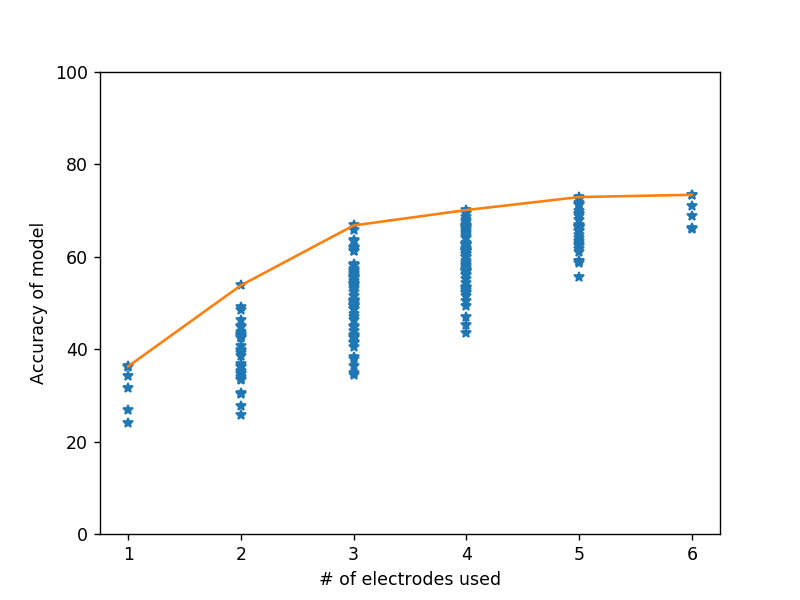

In [11]:
plt.figure()
plt.plot(Xx, Yy, "*")
plt.plot(range(1,7), M_X, "-")
plt.xlabel("# of electrodes used")
plt.ylabel("Accuracy of model")
plt.ylim([0,100])
plt.show()

In [12]:
M_X

[36.29113924050634,
 53.822784810126585,
 66.78987341772151,
 70.12151898734177,
 72.93164556962024,
 73.41898734177215]